In [2]:
import numpy as np
import json

In [1]:
def load_results(feature_probs_path, all_matrices_path):
    with open(feature_probs_path, "r", encoding="utf-8") as f:
        feature_probs = json.load(f)
    with open(all_matrices_path, "r", encoding="utf-8") as f:
        all_matrices = json.load(f)
    # Convert each matrix back to a NumPy array
    for occ in all_matrices:
        all_matrices[occ]["matrix"] = np.array(all_matrices[occ]["matrix"])
    return feature_probs, all_matrices

def compare_results(feature_probs_gen, all_matrices_gen, feature_probs_wiki, all_matrices_wiki):
    difference_feature_probs = {}
    difference_matrices = {}

    # For each occupation in the generated results
    for occ in feature_probs_gen:
        if occ in feature_probs_wiki and occ in all_matrices_gen and occ in all_matrices_wiki:
            # Compare feature probabilities
            common_features = set(feature_probs_gen[occ].keys()).intersection(feature_probs_wiki[occ].keys())
            diff_probs = {}
            for feat in common_features:
                diff_probs[feat] = feature_probs_gen[occ][feat] - feature_probs_wiki[occ][feat]
            difference_feature_probs[occ] = diff_probs

            # Compare matrices: find common features from the top features lists
            features_gen = all_matrices_gen[occ]["features"]
            features_wiki = all_matrices_wiki[occ]["features"]
            common_features_matrix = list(set(features_gen).intersection(features_wiki))
            # Create index maps for both
            idx_gen = {feat: i for i, feat in enumerate(features_gen)}
            idx_wiki = {feat: i for i, feat in enumerate(features_wiki)}
            diff_matrix = np.zeros((len(common_features_matrix), len(common_features_matrix)))
            for i, feat1 in enumerate(common_features_matrix):
                for j, feat2 in enumerate(common_features_matrix):
                    diff_matrix[i, j] = all_matrices_gen[occ]["matrix"][idx_gen[feat1]][idx_gen[feat2]] - \
                                          all_matrices_wiki[occ]["matrix"][idx_wiki[feat1]][idx_wiki[feat2]]
            difference_matrices[occ] = {"features": common_features_matrix, "matrix": diff_matrix.tolist()}
    
    return difference_feature_probs, difference_matrices


In [4]:
# Load results for generated and wiki data
feature_probs_gen, all_matrices_gen = load_results("output/top_ten/feature_probabilities_gen.json", "output/top_ten/all_matrices_gen.json")
feature_probs_wiki, all_matrices_wiki = load_results("output/top_ten/feature_probabilities_wiki.json", "output/top_ten/all_matrices_wiki.json")

# Compare the results
difference_feature_probs, difference_matrices = compare_results(feature_probs_gen, all_matrices_gen, feature_probs_wiki, all_matrices_wiki)


In [5]:

# Save the differences to files
with open("output/top_ten/differences_feature_probs.json", "w", encoding="utf-8") as f:
    json.dump(difference_feature_probs, f, indent=2, ensure_ascii=False)

with open("output/top_ten/differences_matrices.json", "w", encoding="utf-8") as f:
    json.dump(difference_matrices, f, indent=2, ensure_ascii=False)


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap_together(data_gen, data_wiki, occupation):
    """Plot Gen and Wiki heatmaps side by side with the same color scale."""
    
    # Extract data
    features = data_gen['features']  # Assuming both have the same features
    matrix_gen = data_gen['matrix']
    matrix_wiki = data_wiki['matrix']

    # Get global min/max for consistent color scale
    min_val = min(np.min(matrix_gen), np.min(matrix_wiki))
    max_val = max(np.max(matrix_gen), np.max(matrix_wiki))

    # Create subplots for side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Heatmap for Wiki Data
    sns.heatmap(matrix_wiki, xticklabels=features, yticklabels=features,
                cmap='coolwarm', center=0, linewidths=0.5, 
                vmin=min_val, vmax=max_val, cbar_kws={'label': 'Co-occurrence Probability'}, ax=axes[0])
    axes[0].set_title(f'Wiki Feature Co-occurrence for {occupation}', fontsize=14)
    axes[0].set_xticklabels(features, rotation=90, fontsize=8)
    axes[0].set_yticklabels(features, fontsize=8)

    # Heatmap for Gen Data
    sns.heatmap(matrix_gen, xticklabels=features, yticklabels=features,
                cmap='coolwarm', center=0, linewidths=0.5, 
                vmin=min_val, vmax=max_val, cbar_kws={'label': 'Co-occurrence Probability'}, ax=axes[1])
    axes[1].set_title(f'Gen Feature Co-occurrence for {occupation}', fontsize=14)
    axes[1].set_xticklabels(features, rotation=90, fontsize=8)
    axes[1].set_yticklabels(features, fontsize=8)

    plt.tight_layout()
    plt.show()


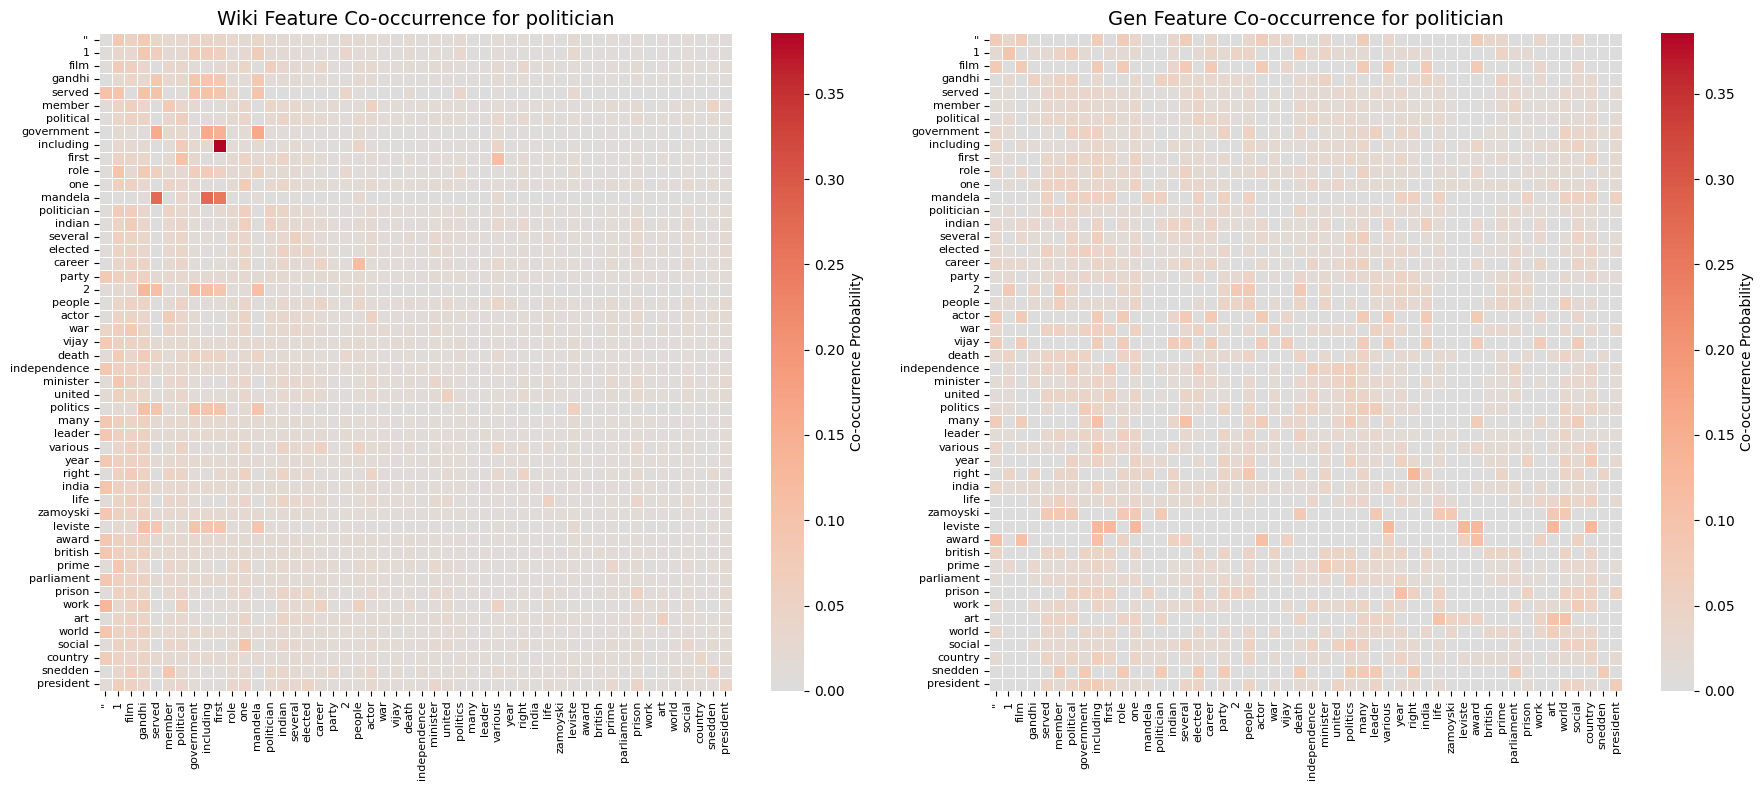

In [9]:
occupation = 'politician'
data_gen = all_matrices_gen[occupation]   # Generated data
data_wiki = all_matrices_wiki[occupation]  # Training/Wikipedia data

plot_heatmap_together(data_gen, data_wiki, occupation)


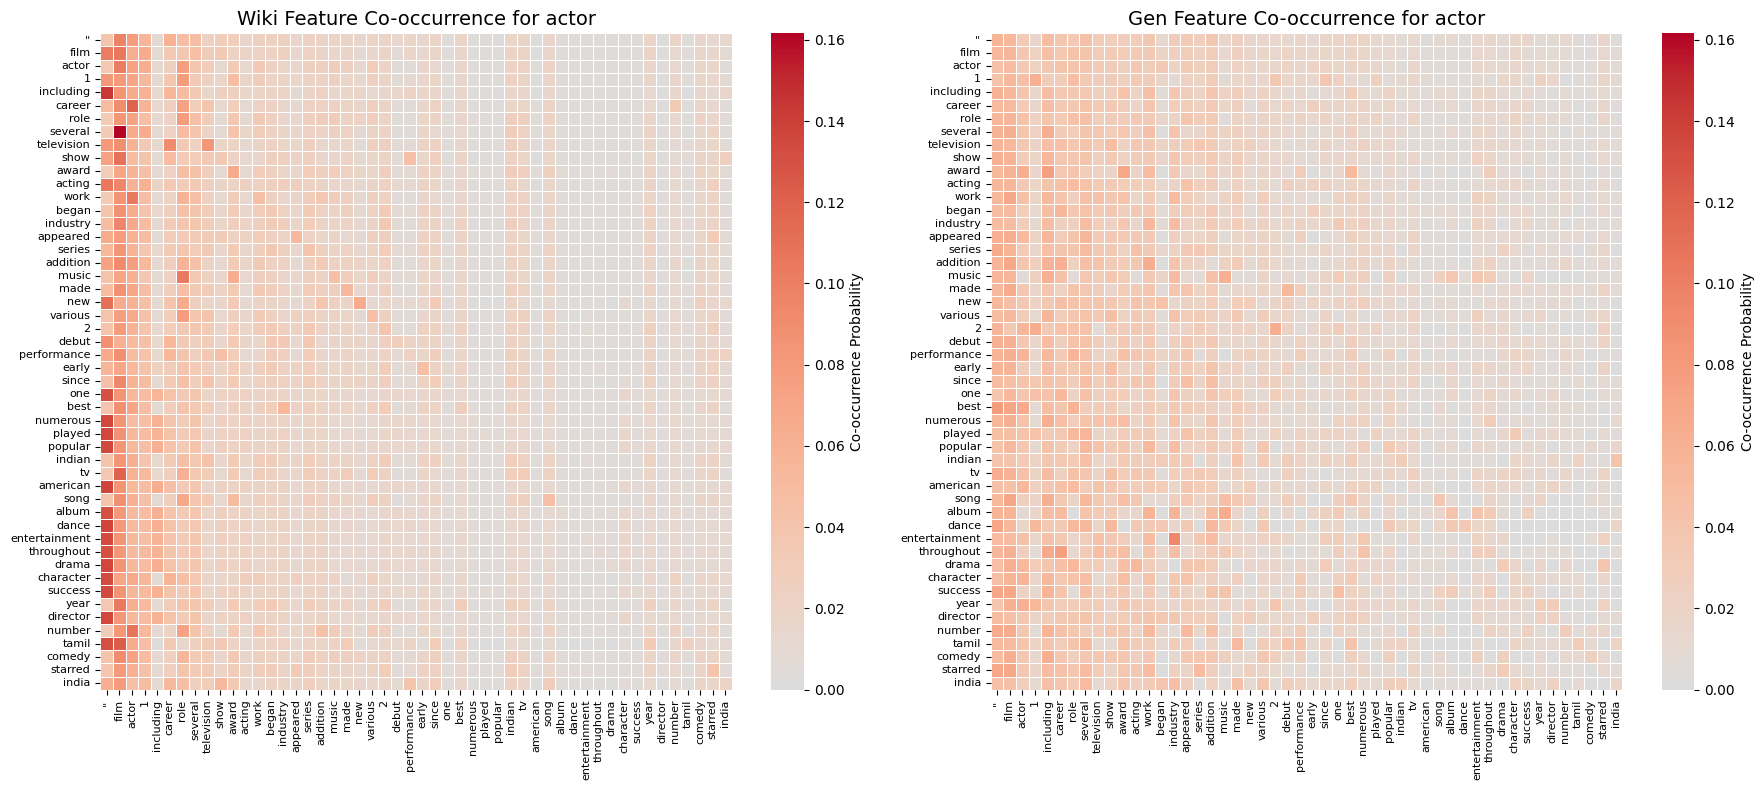

In [10]:
occupation = 'actor'
data_gen = all_matrices_gen[occupation]   # Generated data
data_wiki = all_matrices_wiki[occupation]  # Training/Wikipedia data

plot_heatmap_together(data_gen, data_wiki, occupation)
